In [5]:
import pandas as pd
import numpy as np
from darts import concatenate, TimeSeries
from darts.dataprocessing.transformers import MinTReconciliator  # noqa
from darts.metrics import mae, rmse, mape  # noqa
from darts.models import (
    LinearRegressionModel,
    NaiveSeasonal,
    ExponentialSmoothing 

)
from sklearn.model_selection import train_test_split
from darts.utils.utils import ModelMode, SeasonalityMode
# from darts.utils.likelihood_models import GaussianLikelihood
import matplotlib.pyplot as plt
from tasks_support_system_ai.utils.utils import get_correct_data_path
from tasks_support_system_ai.data.parse_data import read_proper_ts_tree, ts_read_daily_tickets
import seaborn as sns
import random
import matplotlib.cm as cm
from sklearn.ensemble import IsolationForest
import warnings

In [6]:
df = ts_read_daily_tickets(get_correct_data_path("tickets_daily/tickets_daily.csv"))

In [7]:
tree = read_proper_ts_tree(get_correct_data_path("custom_data/tree_proper.csv"))

In [8]:
top_level_tree = tree[(tree["level"] == 1) & (tree["full_load"] != 0)]
top_level_tree.sort_values("full_load", ascending=False)

,queueId,level,immediateDescendants,allDescendants,full_load
7,10,1,"[4472, 472, 4733, 1571, 100118, 2657, 2658, 27...","[10, 104, 462, 472, 1322, 1571, 2190, 2200, 24...",2463146
481,1866,1,"[4307, 4352, 4587, 4667, 4682, 762, 100081, 10...","[762, 1866, 2382, 2733, 3536, 3576, 3617, 3836...",1470013
285,742,1,"[39, 98, 118, 4322, 4412, 2458, 2610, 2921, 3093]","[9, 13, 26, 39, 83, 98, 101, 110, 116, 118, 37...",1387729
26,34,1,"[1, 111, 4522, 842, 1212, 1471, 1531, 1701, 10...","[1, 34, 42, 85, 111, 392, 842, 1212, 1471, 153...",1247019
163,4447,1,"[57, 4457, 4612, 4617, 100254, 100261, 4793, 1...","[57, 382, 1162, 1741, 1881, 1887, 1981, 2007, ...",1121534
485,1871,1,"[4202, 4262, 4723, 100264, 2150, 2170, 2321, 2...","[28, 63, 122, 632, 1062, 1201, 1401, 1871, 198...",1006818
143,4397,1,"[18, 29, 442, 100272, 100042, 2199, 2403, 3750]","[18, 29, 442, 2199, 2240, 2403, 2404, 2535, 32...",986415
90,115,1,"[25, 88, 4547, 4763, 1910, 100044, 100085, 216...","[25, 88, 115, 1910, 2163, 2166, 2219, 2259, 22...",896296
607,2002,1,"[71, 4482, 731, 2226, 2267, 2269, 2298, 2338, ...","[71, 731, 2002, 2226, 2267, 2269, 2298, 2335, ...",825237
41,4147,1,"[7, 14, 4442, 100329, 100034, 100092, 100105, ...","[7, 14, 2544, 3045, 3086, 3095, 3551, 3884, 41...",681754


In [9]:
#Получим датафрейм по конкретному ряду
def get_df_slice(queue_id: int):
    queues = tree[tree["queueId"] == queue_id]["allDescendants"].values[0]
    df_slice = df[df["queueId"].isin(queues)].groupby("date")[["new_tickets"]].sum()
    return df_slice

In [35]:
get_df_slice(10)

,new_tickets
date,
2017-01-01,195
2017-01-02,274
2017-01-03,300
2017-01-04,283
2017-01-05,311
...,...
2020-09-26,2261
2020-09-27,2183
2020-09-28,2880


In [10]:
top_level_queue_ids = top_level_tree['queueId'].tolist()

Попробуем подход gloabal - обучение одной общей модели на всех временных рядах (1-го уровня иерархии).

In [11]:
global_df_top_level = pd.DataFrame()

for queue_id in top_level_queue_ids:
    df_queue = get_df_slice(queue_id)
    df_queue['queue_id'] = queue_id  # Добавляем ID очереди как признак
    global_df_top_level = pd.concat([global_df_top_level, df_queue])

# Reset index чтобы 'date' снова стал столбцом, а не индексом (если нужно)
global_df_top_level = global_df_top_level.reset_index()

global_df_top_level

,date,new_tickets,queue_id
0,2017-01-01,195,10
1,2017-01-02,274,10
2,2017-01-03,300,10
3,2017-01-04,283,10
4,2017-01-05,311,10
...,...,...,...
27819,2020-09-26,299,3936
27820,2020-09-27,330,3936
27821,2020-09-28,494,3936
27822,2020-09-29,554,3936


Начало Feature Engineering

Добавляем временные признаки

In [12]:
def create_time_features(df, date_col='date'):
    """
    Создает временные признаки: день недели, месяц, год.
    """
    df[date_col] = pd.to_datetime(df[date_col])
    df['dayofweek'] = df[date_col].dt.dayofweek  # День недели (0-6, понедельник-воскресенье)
    df['month'] = df[date_col].dt.month          # Месяц (1-12)
    df['year'] = df[date_col].dt.year            # Год
    return df

In [13]:
global_df_top_level = create_time_features(df= global_df_top_level)
global_df_top_level.head(10)

,date,new_tickets,queue_id,dayofweek,month,year
0,2017-01-01,195,10,6,1,2017
1,2017-01-02,274,10,0,1,2017
2,2017-01-03,300,10,1,1,2017
3,2017-01-04,283,10,2,1,2017
4,2017-01-05,311,10,3,1,2017
5,2017-01-06,283,10,4,1,2017
6,2017-01-07,314,10,5,1,2017
7,2017-01-08,302,10,6,1,2017
8,2017-01-09,2252,10,0,1,2017
9,2017-01-10,711,10,1,1,2017


In [14]:
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from tqdm import tqdm

Выбор признаков и целевой переменной

In [15]:
features = [col for col in global_df_top_level.columns if col not in ['date', 'new_tickets', 'year']]

target = 'new_tickets'

In [16]:
def create_X_y(global_df_top_level, features, target):
    X = global_df_top_level[features]
    y = global_df_top_level[target]
    groups = global_df_top_level['queue_id']
    return X, y, groups

In [ ]:
X, y, groups = create_X_y(
    global_df_top_level= global_df_top_level,
    features= features,
    target= target
    )

Обучим CatBoost. В качестве категориальных признаков - номер очереди

In [96]:
def cb_fitting(X, y, groups):
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)


    model_cb = CatBoostRegressor(random_state=42, verbose=5, cat_features=['queue_id'])


    mae_scores_cb = []
    rmse_scores_cb = []
    mape_scores_cb = []

    for train_index, test_index in tqdm(tscv.split(X, y, groups=groups)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_cb.fit(X_train, y_train)

        y_pred_cb = model_cb.predict(X_test)

        mape_cb = mean_absolute_percentage_error(y_test, y_pred_cb)
        rmse_cb = root_mean_squared_error(y_test, y_pred_cb)
        mae_cb = mean_absolute_error(y_test, y_pred_cb)

        mae_scores_cb.append(mae_cb)
        rmse_scores_cb.append(rmse_cb)
        mape_scores_cb.append(mape_cb)

    avg_mae_cb = np.mean(mae_scores_cb)
    avg_rmse_cb = np.mean(rmse_scores_cb)
    avg_mape_cb = np.mean(mape_scores_cb)
    return model_cb, avg_mae_cb, avg_rmse_cb, avg_mape_cb


In [ ]:
model, avg_mae, avg_rmse, avg_mape = cb_fitting(
    X= X,
    y= y,
    groups= groups
    )
print("Результаты CatBoost:")
print(f"Средний RMSE на кросс-валидации: {avg_rmse:.2f}")
print(f"Средний MAE на кросс-валидации: {avg_mae:.2f}")
print(f"Средний MAPE на кросс-валидации: {avg_mape:.2f}")

Результаты CatBoost:
Средний RMSE на кросс-валидации: 529.14
Средний MAE на кросс-валидации: 389.13
Средний MAPE на кросс-валидации: 14.03


Пока что метрики хуже чем из бейзлайна , но там мы смотрели на очереди по отдельности, поэтому не совсем корректно сравнивать.
Продолжим Feature Engineering

Создаем лаговые признаки

In [17]:
def create_lag_features(df, lags, queue_id_col='queue_id', target_col='new_tickets'):
    """
    Создает лаговые признаки для временного ряда в DataFrame.
    """
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df.groupby(queue_id_col)[target_col].shift(lag)
    return df

lags_to_create = [1, 2, 3, 7, 14, 21, 28, 30]

In [18]:
global_df_top_level = create_lag_features(global_df_top_level, lags_to_create)
global_df_top_level

,date,new_tickets,queue_id,dayofweek,month,year,new_tickets_lag_1,new_tickets_lag_2,new_tickets_lag_3,new_tickets_lag_7,new_tickets_lag_14,new_tickets_lag_21,new_tickets_lag_28,new_tickets_lag_30
0,2017-01-01,195,10,6,1,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,274,10,0,1,2017,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-03,300,10,1,1,2017,274.0,195.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-04,283,10,2,1,2017,300.0,274.0,195.0,NaN,NaN,NaN,NaN,NaN
4,2017-01-05,311,10,3,1,2017,283.0,300.0,274.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27819,2020-09-26,299,3936,5,9,2020,428.0,454.0,478.0,326.0,361.0,396.0,354.0,470.0
27820,2020-09-27,330,3936,6,9,2020,299.0,428.0,454.0,314.0,413.0,449.0,301.0,394.0
27821,2020-09-28,494,3936,0,9,2020,330.0,299.0,428.0,438.0,455.0,568.0,360.0,354.0
27822,2020-09-29,554,3936,1,9,2020,494.0,330.0,299.0,449.0,460.0,561.0,475.0,301.0


In [19]:
global_df_top_level = global_df_top_level.dropna()
global_df_top_level

,date,new_tickets,queue_id,dayofweek,month,year,new_tickets_lag_1,new_tickets_lag_2,new_tickets_lag_3,new_tickets_lag_7,new_tickets_lag_14,new_tickets_lag_21,new_tickets_lag_28,new_tickets_lag_30
30,2017-01-31,705,10,1,1,2017,694.0,305.0,318.0,818.0,798.0,711.0,300.0,195.0
31,2017-02-01,648,10,2,2,2017,705.0,694.0,305.0,608.0,639.0,605.0,283.0,274.0
32,2017-02-02,600,10,3,2,2017,648.0,705.0,694.0,689.0,689.0,797.0,311.0,300.0
33,2017-02-03,640,10,4,2,2017,600.0,648.0,705.0,603.0,624.0,672.0,283.0,283.0
34,2017-02-04,327,10,5,2,2017,640.0,600.0,648.0,318.0,362.0,366.0,314.0,311.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27819,2020-09-26,299,3936,5,9,2020,428.0,454.0,478.0,326.0,361.0,396.0,354.0,470.0
27820,2020-09-27,330,3936,6,9,2020,299.0,428.0,454.0,314.0,413.0,449.0,301.0,394.0
27821,2020-09-28,494,3936,0,9,2020,330.0,299.0,428.0,438.0,455.0,568.0,360.0,354.0
27822,2020-09-29,554,3936,1,9,2020,494.0,330.0,299.0,449.0,460.0,561.0,475.0,301.0


In [20]:
features = [col for col in global_df_top_level.columns if col not in ['date', 'new_tickets', 'year']]

target = 'new_tickets'

In [ ]:
X, y, groups = create_X_y(
    global_df_top_level= global_df_top_level,
    features= features,
    target= target
    )

,queue_id,tickets_lag_1,tickets_lag_2,tickets_lag_3,tickets_lag_7,tickets_lag_14,tickets_lag_21,tickets_lag_28,tickets_lag_30
30,10,694.0,305.0,318.0,818.0,798.0,711.0,300.0,195.0
31,10,705.0,694.0,305.0,608.0,639.0,605.0,283.0,274.0
32,10,648.0,705.0,694.0,689.0,689.0,797.0,311.0,300.0
33,10,600.0,648.0,705.0,603.0,624.0,672.0,283.0,283.0
34,10,640.0,600.0,648.0,318.0,362.0,366.0,314.0,311.0
...,...,...,...,...,...,...,...,...,...
27819,3936,428.0,454.0,478.0,326.0,361.0,396.0,354.0,470.0
27820,3936,299.0,428.0,454.0,314.0,413.0,449.0,301.0,394.0
27821,3936,330.0,299.0,428.0,438.0,455.0,568.0,360.0,354.0
27822,3936,494.0,330.0,299.0,449.0,460.0,561.0,475.0,301.0


In [97]:
model, avg_mae, avg_rmse, avg_mape = cb_fitting(
    X= X,
    y= y,
    groups= groups
    )
print("Результаты CatBoost c лагами:")
print(f"Средний RMSE на кросс-валидации: {avg_rmse:.2f}")
print(f"Средний MAE на кросс-валидации: {avg_mae:.2f}")
print(f"Средний MAPE на кросс-валидации: {avg_mape:.2f}")

c:\Users\SUBRU\AppData\Roaming\pypoetry\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
0it [00:00, ?it/s]

Learning rate set to 0.051979
0:	learn: 942.4321122	total: 22.4ms	remaining: 22.4s
5:	learn: 788.7552733	total: 138ms	remaining: 22.8s
10:	learn: 675.9044646	total: 267ms	remaining: 24s
15:	learn: 594.3007716	total: 386ms	remaining: 23.7s
20:	learn: 535.5858461	total: 508ms	remaining: 23.7s
25:	learn: 493.6202212	total: 642ms	remaining: 24.1s
30:	learn: 461.5374748	total: 786ms	remaining: 24.6s
35:	learn: 437.3725231	total: 928ms	remaining: 24.9s
40:	learn: 416.5361057	total: 1.07s	remaining: 25s
45:	learn: 401.2377223	total: 1.2s	remaining: 24.9s
50:	learn: 388.8539629	total: 1.34s	remaining: 24.9s
55:	learn: 378.8058720	total: 1.47s	remaining: 24.8s
60:	learn: 368.8761974	total: 1.6s	remaining: 24.7s
65:	learn: 361.3122697	total: 1.73s	remaining: 24.5s
70:	learn: 355.0021437	total: 1.86s	remaining: 24.4s
75:	learn: 349.2356723	total: 1.99s	remaining: 24.2s
80:	learn: 344.7532741	total: 2.12s	remaining: 24.1s
85:	learn: 340.8082764	total: 2.25s	remaining: 23.9s
90:	learn: 337.0727608	

1it [00:28, 28.23s/it]

999:	learn: 113.9063920	total: 28s	remaining: 0us
Learning rate set to 0.057993
0:	learn: 751.6294761	total: 28.1ms	remaining: 28.1s
5:	learn: 612.2086516	total: 164ms	remaining: 27.2s
10:	learn: 514.4057638	total: 305ms	remaining: 27.4s
15:	learn: 446.6385249	total: 454ms	remaining: 27.9s
20:	learn: 398.3675130	total: 597ms	remaining: 27.8s
25:	learn: 367.6616098	total: 746ms	remaining: 27.9s
30:	learn: 344.5395771	total: 886ms	remaining: 27.7s
35:	learn: 325.2911787	total: 1.07s	remaining: 28.6s
40:	learn: 314.8457306	total: 1.22s	remaining: 28.6s
45:	learn: 303.2971030	total: 1.4s	remaining: 29s
50:	learn: 294.2461029	total: 1.55s	remaining: 28.9s
55:	learn: 286.9264982	total: 1.7s	remaining: 28.7s
60:	learn: 281.9184239	total: 1.84s	remaining: 28.3s
65:	learn: 275.6124911	total: 1.98s	remaining: 28.1s
70:	learn: 270.5180626	total: 2.15s	remaining: 28.1s
75:	learn: 266.2293245	total: 2.32s	remaining: 28.2s
80:	learn: 260.4634354	total: 2.48s	remaining: 28.1s
85:	learn: 258.1533726	t

2it [00:59, 30.23s/it]

995:	learn: 102.5665370	total: 31.3s	remaining: 126ms
999:	learn: 102.3371791	total: 31.4s	remaining: 0us
Learning rate set to 0.061829
0:	learn: 684.8711257	total: 29.6ms	remaining: 29.6s
5:	learn: 550.9682094	total: 209ms	remaining: 34.6s
10:	learn: 460.4414876	total: 372ms	remaining: 33.5s
15:	learn: 400.7640943	total: 540ms	remaining: 33.2s
20:	learn: 362.7963794	total: 711ms	remaining: 33.1s
25:	learn: 336.0465514	total: 884ms	remaining: 33.1s
30:	learn: 316.2519190	total: 1.04s	remaining: 32.7s
35:	learn: 305.0538689	total: 1.23s	remaining: 33.1s
40:	learn: 297.0797559	total: 1.4s	remaining: 32.7s
45:	learn: 288.6517784	total: 1.59s	remaining: 33s
50:	learn: 281.4555253	total: 1.76s	remaining: 32.7s
55:	learn: 275.3870854	total: 1.93s	remaining: 32.5s
60:	learn: 270.9195927	total: 2.08s	remaining: 32.1s
65:	learn: 265.8489902	total: 2.25s	remaining: 31.8s
70:	learn: 262.8254005	total: 2.42s	remaining: 31.7s
75:	learn: 259.8449712	total: 2.6s	remaining: 31.6s
80:	learn: 256.555389

3it [01:31, 30.87s/it]

995:	learn: 134.0397138	total: 31.3s	remaining: 126ms
999:	learn: 133.8564496	total: 31.4s	remaining: 0us
Learning rate set to 0.064704
0:	learn: 668.8956356	total: 27.6ms	remaining: 27.6s
5:	learn: 530.2169865	total: 176ms	remaining: 29.2s
10:	learn: 437.4471117	total: 339ms	remaining: 30.5s
15:	learn: 377.8265269	total: 532ms	remaining: 32.7s
20:	learn: 339.4596673	total: 719ms	remaining: 33.5s
25:	learn: 315.3853657	total: 875ms	remaining: 32.8s
30:	learn: 298.1491968	total: 1.04s	remaining: 32.5s
35:	learn: 285.8973907	total: 1.2s	remaining: 32.2s
40:	learn: 278.7253889	total: 1.36s	remaining: 31.8s
45:	learn: 271.8610571	total: 1.51s	remaining: 31.4s
50:	learn: 267.5867844	total: 1.66s	remaining: 31s
55:	learn: 263.4500781	total: 1.83s	remaining: 30.8s
60:	learn: 259.3207884	total: 2.02s	remaining: 31.1s
65:	learn: 255.5207221	total: 2.18s	remaining: 30.9s
70:	learn: 252.0954662	total: 2.36s	remaining: 30.8s
75:	learn: 249.2640944	total: 2.52s	remaining: 30.7s
80:	learn: 247.22906

4it [02:06, 32.58s/it]

995:	learn: 146.5545939	total: 34.8s	remaining: 140ms
999:	learn: 146.3794576	total: 35s	remaining: 0us
Learning rate set to 0.067026
0:	learn: 614.9540709	total: 35.1ms	remaining: 35s
5:	learn: 482.4844818	total: 226ms	remaining: 37.4s
10:	learn: 396.2907384	total: 409ms	remaining: 36.8s
15:	learn: 340.3707328	total: 605ms	remaining: 37.2s
20:	learn: 306.2460603	total: 794ms	remaining: 37s
25:	learn: 284.0521459	total: 967ms	remaining: 36.2s
30:	learn: 269.5147161	total: 1.17s	remaining: 36.6s
35:	learn: 258.3317754	total: 1.34s	remaining: 35.8s
40:	learn: 249.5773248	total: 1.54s	remaining: 36.1s
45:	learn: 243.6573708	total: 1.72s	remaining: 35.6s
50:	learn: 239.3130222	total: 1.91s	remaining: 35.5s
55:	learn: 235.9921907	total: 2.08s	remaining: 35.1s
60:	learn: 232.6555339	total: 2.26s	remaining: 34.8s
65:	learn: 227.9758095	total: 2.47s	remaining: 34.9s
70:	learn: 224.5709629	total: 2.65s	remaining: 34.6s
75:	learn: 222.9750625	total: 2.84s	remaining: 34.6s
80:	learn: 220.7093321	

5it [02:38, 31.72s/it]

999:	learn: 132.1563710	total: 31.7s	remaining: 0us
Результаты CatBoost c лагами:
Средний RMSE на кросс-валидации: 196.47
Средний MAE на кросс-валидации: 90.14
Средний MAPE на кросс-валидации: 0.68


Результаты CatBoost c лагами:
Средний RMSE на кросс-валидации: 196.47
Средний MAE на кросс-валидации: 90.14
Средний MAPE на кросс-валидации: 0.68

Проверим на 10ой очереди , чтобы сравнить с baseline решением

In [21]:
df_10 = global_df_top_level[global_df_top_level['queue_id'] == 10].copy()

In [101]:
X, y, groups = create_X_y(
    global_df_top_level= df_10,
    features= features,
    target= target
    )

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42)

y_pred_compare = model.predict(X_test)

In [110]:
print("Результаты CatBoost c лагами для 10ой очереди:")
print(f"RMSE: {root_mean_squared_error(y_true= y_test, y_pred= y_pred_compare):.2f}")
print(f"MAE: {mean_absolute_error(y_true= y_test, y_pred= y_pred_compare):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_true= y_test, y_pred= y_pred_compare):.2f}")

Результаты CatBoost c лагами для 10ой очереди:
RMSE: 188.01
MAE: 134.46
MAPE: 0.08


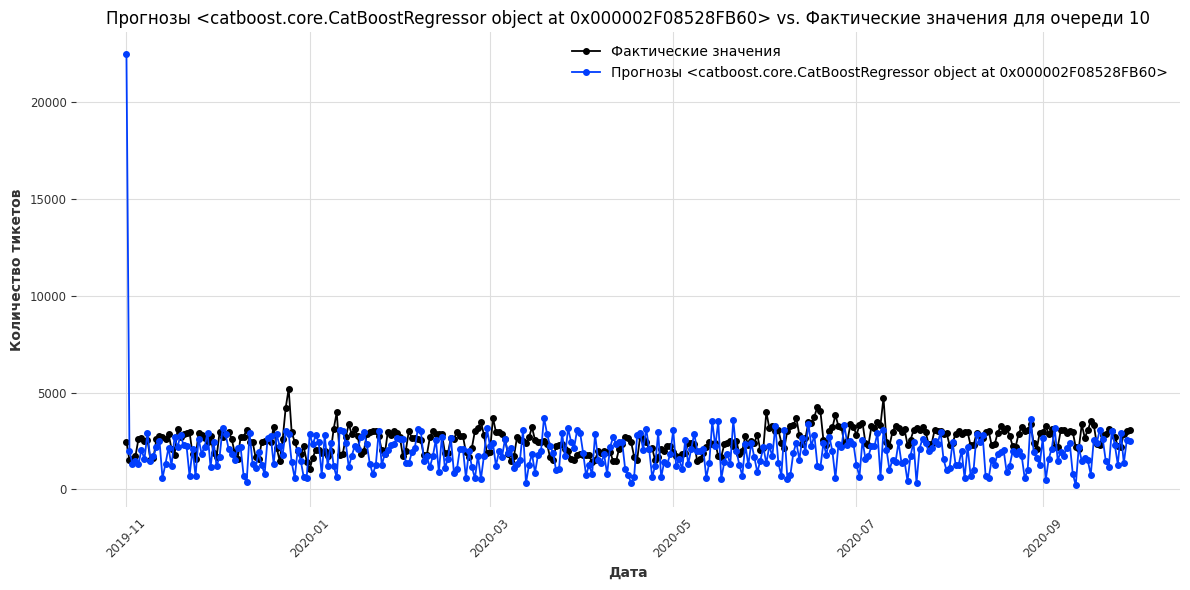

In [136]:
plt.figure(figsize=(12, 6))
plt.plot(df_10['date'].iloc[1004:], df_10['tickets'].iloc[1004:], label='Фактические значения', marker='o', markersize=4) 
plt.plot(df_10['date'].iloc[1004:], y_pred_compare, label=f'Прогнозы {model}', marker='o', markersize=4) 
plt.xlabel('Дата')
plt.ylabel('Количество тикетов')
plt.title(f'Прогнозы {model} vs. Фактические значения для очереди {10}')
plt.grid(True) 
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

Добавим бинарный признак аномалий (алгоритм Isolation Forest)

In [23]:
from sklearn.ensemble import IsolationForest
def create_anomaly_feature(df, queue_id_col='queue_id', date_col='date', target_col='new_tickets', contamination=0.05, random_state=42):
    """
    Создает бинарный признак 'is_anomaly' на основе детекции аномалий с помощью Isolation Forest.
    Детекция аномалий выполняется отдельно для каждого временного ряда (очереди).
    """

    df['is_anomaly'] = 0  # Инициализируем колонку 'is_anomaly' нулями

    for queue_id in df[queue_id_col].unique():
        df_queue = df[df[queue_id_col] == queue_id].copy() 

        
        model_if = IsolationForest(contamination=contamination, random_state=random_state)
        model_if.fit(df_queue[[target_col]]) 

       
        anomaly_labels = model_if.predict(df_queue[[target_col]])


        is_anomaly_flag = (anomaly_labels == -1).astype(int) 

  
        df.loc[df[queue_id_col] == queue_id, 'is_anomaly'] = is_anomaly_flag 


    return df

In [24]:
global_df_top_level_anomaly = create_anomaly_feature(global_df_top_level)
global_df_top_level_anomaly.head(10)

C:\Users\SUBRU\AppData\Local\Temp\ipykernel_25076\2493274749.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_anomaly'] = 0  # Инициализируем колонку 'is_anomaly' нулями


,date,new_tickets,queue_id,dayofweek,month,year,new_tickets_lag_1,new_tickets_lag_2,new_tickets_lag_3,new_tickets_lag_7,new_tickets_lag_14,new_tickets_lag_21,new_tickets_lag_28,new_tickets_lag_30,is_anomaly
30,2017-01-31,705,10,1,1,2017,694.0,305.0,318.0,818.0,798.0,711.0,300.0,195.0,0
31,2017-02-01,648,10,2,2,2017,705.0,694.0,305.0,608.0,639.0,605.0,283.0,274.0,0
32,2017-02-02,600,10,3,2,2017,648.0,705.0,694.0,689.0,689.0,797.0,311.0,300.0,0
33,2017-02-03,640,10,4,2,2017,600.0,648.0,705.0,603.0,624.0,672.0,283.0,283.0,0
34,2017-02-04,327,10,5,2,2017,640.0,600.0,648.0,318.0,362.0,366.0,314.0,311.0,0
35,2017-02-05,280,10,6,2,2017,327.0,640.0,600.0,305.0,300.0,402.0,302.0,283.0,1
36,2017-02-06,669,10,0,2,2017,280.0,327.0,640.0,694.0,844.0,672.0,2252.0,314.0,0
37,2017-02-07,619,10,1,2,2017,669.0,280.0,327.0,705.0,818.0,798.0,711.0,302.0,0
38,2017-02-08,620,10,2,2,2017,619.0,669.0,280.0,648.0,608.0,639.0,605.0,2252.0,0
39,2017-02-09,739,10,3,2,2017,620.0,619.0,669.0,600.0,689.0,689.0,797.0,711.0,0


In [25]:
features = [col for col in global_df_top_level_anomaly.columns if col not in ['date', 'new_tickets', 'year']]

target = 'new_tickets'

In [ ]:
X, y, groups = create_X_y(
    global_df_top_level= global_df_top_level_anomaly,
    features= features,
    target= target
    )

In [171]:
model_anomaly, avg_mae, avg_rmse, avg_mape = cb_fitting(
    X= X,
    y= y,
    groups= groups
    )
print("Результаты CatBoost c лагами и аномалиями:")
print(f"Средний RMSE на кросс-валидации: {avg_rmse:.2f}")
print(f"Средний MAE на кросс-валидации: {avg_mae:.2f}")
print(f"Средний MAPE на кросс-валидации: {avg_mape:.2f}")

c:\Users\SUBRU\AppData\Roaming\pypoetry\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning:

The groups parameter is ignored by TimeSeriesSplit

0it [00:00, ?it/s]

Learning rate set to 0.051979
0:	learn: 943.5241408	total: 20.8ms	remaining: 20.8s
5:	learn: 785.2357161	total: 139ms	remaining: 23.1s
10:	learn: 660.2449018	total: 262ms	remaining: 23.6s
15:	learn: 568.5185215	total: 397ms	remaining: 24.4s
20:	learn: 497.9266789	total: 535ms	remaining: 24.9s
25:	learn: 443.7665739	total: 665ms	remaining: 24.9s
30:	learn: 402.1724205	total: 819ms	remaining: 25.6s
35:	learn: 371.7621427	total: 965ms	remaining: 25.8s
40:	learn: 348.5786848	total: 1.12s	remaining: 26.2s
45:	learn: 327.3317789	total: 1.27s	remaining: 26.3s
50:	learn: 309.7606454	total: 1.42s	remaining: 26.4s
55:	learn: 296.5341342	total: 1.56s	remaining: 26.3s
60:	learn: 285.6598354	total: 1.69s	remaining: 26s
65:	learn: 275.7331237	total: 1.82s	remaining: 25.7s
70:	learn: 268.2017495	total: 1.94s	remaining: 25.4s
75:	learn: 261.9501966	total: 2.07s	remaining: 25.2s
80:	learn: 255.7900861	total: 2.24s	remaining: 25.4s
85:	learn: 250.1265223	total: 2.36s	remaining: 25.1s
90:	learn: 245.4075

1it [00:27, 27.08s/it]

999:	learn: 90.2129394	total: 26.9s	remaining: 0us
Learning rate set to 0.057993
0:	learn: 751.1201497	total: 27.5ms	remaining: 27.5s
5:	learn: 609.3101214	total: 168ms	remaining: 27.9s
10:	learn: 508.3689423	total: 310ms	remaining: 27.9s
15:	learn: 439.3846164	total: 452ms	remaining: 27.8s
20:	learn: 390.6453965	total: 592ms	remaining: 27.6s
25:	learn: 356.1059243	total: 744ms	remaining: 27.9s
30:	learn: 330.5214168	total: 893ms	remaining: 27.9s
35:	learn: 308.4269452	total: 1.04s	remaining: 27.8s
40:	learn: 292.7775681	total: 1.18s	remaining: 27.6s
45:	learn: 279.0315273	total: 1.33s	remaining: 27.5s
50:	learn: 266.4879409	total: 1.47s	remaining: 27.4s
55:	learn: 257.4419845	total: 1.62s	remaining: 27.3s
60:	learn: 247.4829808	total: 1.76s	remaining: 27.1s
65:	learn: 238.9268324	total: 1.9s	remaining: 27s
70:	learn: 233.7712967	total: 2.04s	remaining: 26.7s
75:	learn: 228.1877514	total: 2.2s	remaining: 26.7s
80:	learn: 224.7580921	total: 2.35s	remaining: 26.7s
85:	learn: 220.2725479	

2it [00:54, 27.36s/it]

995:	learn: 81.1055949	total: 27.3s	remaining: 109ms
999:	learn: 80.9679555	total: 27.4s	remaining: 0us
Learning rate set to 0.061829
0:	learn: 684.8385168	total: 31.2ms	remaining: 31.2s
5:	learn: 549.6696460	total: 208ms	remaining: 34.5s
10:	learn: 456.0303896	total: 374ms	remaining: 33.6s
15:	learn: 393.3798485	total: 521ms	remaining: 32.1s
20:	learn: 350.7398856	total: 672ms	remaining: 31.3s
25:	learn: 317.6241551	total: 820ms	remaining: 30.7s
30:	learn: 293.2174402	total: 970ms	remaining: 30.3s
35:	learn: 274.5696985	total: 1.12s	remaining: 30s
40:	learn: 262.4344002	total: 1.27s	remaining: 29.7s
45:	learn: 253.0040314	total: 1.42s	remaining: 29.4s
50:	learn: 244.7388193	total: 1.57s	remaining: 29.2s
55:	learn: 237.1928229	total: 1.72s	remaining: 29s
60:	learn: 231.3371542	total: 1.87s	remaining: 28.8s
65:	learn: 226.6014639	total: 2.02s	remaining: 28.6s
70:	learn: 222.3910402	total: 2.17s	remaining: 28.4s
75:	learn: 218.6949125	total: 2.33s	remaining: 28.3s
80:	learn: 214.8502164	

3it [01:23, 28.13s/it]

999:	learn: 103.5694029	total: 28.8s	remaining: 0us
Learning rate set to 0.064704
0:	learn: 669.2214862	total: 29.5ms	remaining: 29.4s
5:	learn: 528.2588436	total: 179ms	remaining: 29.7s
10:	learn: 431.2146367	total: 329ms	remaining: 29.5s
15:	learn: 366.2957024	total: 482ms	remaining: 29.6s
20:	learn: 324.8099132	total: 632ms	remaining: 29.5s
25:	learn: 297.7471348	total: 789ms	remaining: 29.5s
30:	learn: 278.7528637	total: 939ms	remaining: 29.4s
35:	learn: 265.9945022	total: 1.1s	remaining: 29.5s
40:	learn: 256.0799270	total: 1.25s	remaining: 29.3s
45:	learn: 249.9438894	total: 1.41s	remaining: 29.3s
50:	learn: 244.3735464	total: 1.58s	remaining: 29.4s
55:	learn: 239.9943093	total: 1.73s	remaining: 29.2s
60:	learn: 236.2508914	total: 1.88s	remaining: 29s
65:	learn: 232.5950746	total: 2.04s	remaining: 28.8s
70:	learn: 228.7154892	total: 2.19s	remaining: 28.7s
75:	learn: 225.9624242	total: 2.35s	remaining: 28.6s
80:	learn: 223.8724355	total: 2.5s	remaining: 28.4s
85:	learn: 221.3231658

4it [01:53, 28.75s/it]

995:	learn: 119.7032191	total: 29.4s	remaining: 118ms
999:	learn: 119.4672593	total: 29.5s	remaining: 0us
Learning rate set to 0.067026
0:	learn: 615.1085786	total: 28.5ms	remaining: 28.5s
5:	learn: 481.6134773	total: 184ms	remaining: 30.4s
10:	learn: 392.7414361	total: 345ms	remaining: 31s
15:	learn: 335.5305702	total: 504ms	remaining: 31s
20:	learn: 296.5400194	total: 662ms	remaining: 30.8s
25:	learn: 269.5477049	total: 815ms	remaining: 30.5s
30:	learn: 253.2833752	total: 974ms	remaining: 30.5s
35:	learn: 241.1610645	total: 1.13s	remaining: 30.2s
40:	learn: 232.1733561	total: 1.28s	remaining: 30.1s
45:	learn: 225.2136673	total: 1.45s	remaining: 30s
50:	learn: 219.6328745	total: 1.61s	remaining: 30.1s
55:	learn: 214.7478584	total: 1.77s	remaining: 29.9s
60:	learn: 211.2904601	total: 1.93s	remaining: 29.7s
65:	learn: 208.3931693	total: 2.09s	remaining: 29.6s
70:	learn: 204.9844526	total: 2.25s	remaining: 29.4s
75:	learn: 202.4339615	total: 2.4s	remaining: 29.2s
80:	learn: 199.6839954	t

5it [02:23, 28.78s/it]

999:	learn: 103.5064648	total: 30.3s	remaining: 0us
Результаты CatBoost c лагами и аномалиями:
Средний RMSE на кросс-валидации: 176.43
Средний MAE на кросс-валидации: 91.70
Средний MAPE на кросс-валидации: 1.35


RMSE стала еще меньше. Для Isolation Forest выбрал contamination = 0.05. Пробовал auto и 0.03 - были хуже результаты
Результаты CatBoost c лагами и аномалиями:
Средний RMSE на кросс-валидации: 176.43
Средний MAE на кросс-валидации: 91.70
Средний MAPE на кросс-валидации: 1.35

Добавлю еще признаков - скользящие статистики на лаговых признаках

In [26]:
def create_rolling_lag_features(df, lags, windows, queue_id_col='queue_id', target_col='new_tickets', statistics=['mean', 'median', 'std']):
    """
    Создает признаки скользящих статистик для лаговых признаков временного ряда.
    """

    for lag in lags:
        for window in windows:
            for stat in statistics:
                col_name = f'{target_col}_lag_{lag}_rolling_{stat}_{window}'
                if stat == 'mean':
                    df[col_name] = df.groupby(queue_id_col)[f'{target_col}_lag_{lag}'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
                elif stat == 'median':
                    df[col_name] = df.groupby(queue_id_col)[f'{target_col}_lag_{lag}'].rolling(window=window, min_periods=1).median().reset_index(level=0, drop=True)
                elif stat == 'std':
                    df[col_name] = df.groupby(queue_id_col)[f'{target_col}_lag_{lag}'].rolling(window=window, min_periods=1).std().reset_index(level=0, drop=True)
                else:
                    raise ValueError(f"Statistic '{stat}' is not supported. Choose from 'mean', 'median', 'std'.")
    return df

In [27]:
lags_for_rolling = [1, 7, 14]
windows_for_rolling = [3, 7, 14]

In [28]:
global_df_top_level_statistics = create_rolling_lag_features(global_df_top_level_anomaly, lags_for_rolling, windows_for_rolling)
global_df_top_level_statistics.head(10)

C:\Users\SUBRU\AppData\Local\Temp\ipykernel_25076\1106510558.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.groupby(queue_id_col)[f'{target_col}_lag_{lag}'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
C:\Users\SUBRU\AppData\Local\Temp\ipykernel_25076\1106510558.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.groupby(queue_id_col)[f'{target_col}_lag_{lag}'].rolling(window=window, min_periods=1).median().reset_index(level=0, drop=

,date,new_tickets,queue_id,dayofweek,month,year,new_tickets_lag_1,new_tickets_lag_2,new_tickets_lag_3,new_tickets_lag_7,...,new_tickets_lag_7_rolling_std_14,new_tickets_lag_14_rolling_mean_3,new_tickets_lag_14_rolling_median_3,new_tickets_lag_14_rolling_std_3,new_tickets_lag_14_rolling_mean_7,new_tickets_lag_14_rolling_median_7,new_tickets_lag_14_rolling_std_7,new_tickets_lag_14_rolling_mean_14,new_tickets_lag_14_rolling_median_14,new_tickets_lag_14_rolling_std_14
30,2017-01-31,705,10,1,1,2017,694.0,305.0,318.0,818.0,...,NaN,798.000000,798.0,NaN,798.000000,798.0,NaN,798.000000,798.0,NaN
31,2017-02-01,648,10,2,2,2017,705.0,694.0,305.0,608.0,...,148.492424,718.500000,718.5,112.429978,718.500000,718.5,112.429978,718.500000,718.5,112.429978
32,2017-02-02,600,10,3,2,2017,648.0,705.0,694.0,689.0,...,105.910339,708.666667,689.0,81.303956,708.666667,689.0,81.303956,708.666667,689.0,81.303956
33,2017-02-03,640,10,4,2,2017,600.0,648.0,705.0,603.0,...,100.394223,650.666667,639.0,34.034296,687.500000,664.0,78.733728,687.500000,664.0,78.733728
34,2017-02-04,327,10,5,2,2017,640.0,600.0,648.0,318.0,...,183.563885,558.333333,624.0,173.107866,622.400000,639.0,160.746073,622.400000,639.0,160.746073
35,2017-02-05,280,10,6,2,2017,327.0,640.0,600.0,305.0,...,205.371290,428.666667,362.0,171.980619,568.666667,631.5,194.923233,568.666667,631.5,194.923233
36,2017-02-06,669,10,0,2,2017,280.0,327.0,640.0,694.0,...,194.513802,502.000000,362.0,297.798590,608.000000,639.0,206.136686,608.000000,639.0,206.136686
37,2017-02-07,619,10,1,2,2017,669.0,280.0,327.0,705.0,...,185.733296,654.000000,818.0,306.848497,610.857143,639.0,209.323059,634.250000,664.0,204.779149
38,2017-02-08,620,10,2,2,2017,619.0,669.0,280.0,648.0,...,174.719776,756.666667,818.0,129.403761,606.428571,624.0,208.956022,631.333333,639.0,191.753096
39,2017-02-09,739,10,3,2,2017,620.0,619.0,669.0,600.0,...,164.727924,705.000000,689.0,105.910339,606.428571,624.0,208.956022,637.100000,664.0,181.703941


In [29]:
global_df_top_level_statistics = global_df_top_level_statistics.dropna()
global_df_top_level_statistics

,date,new_tickets,queue_id,dayofweek,month,year,new_tickets_lag_1,new_tickets_lag_2,new_tickets_lag_3,new_tickets_lag_7,...,new_tickets_lag_7_rolling_std_14,new_tickets_lag_14_rolling_mean_3,new_tickets_lag_14_rolling_median_3,new_tickets_lag_14_rolling_std_3,new_tickets_lag_14_rolling_mean_7,new_tickets_lag_14_rolling_median_7,new_tickets_lag_14_rolling_std_7,new_tickets_lag_14_rolling_mean_14,new_tickets_lag_14_rolling_median_14,new_tickets_lag_14_rolling_std_14
31,2017-02-01,648,10,2,2,2017,705.0,694.0,305.0,608.0,...,148.492424,718.500000,718.5,112.429978,718.500000,718.5,112.429978,718.500000,718.5,112.429978
32,2017-02-02,600,10,3,2,2017,648.0,705.0,694.0,689.0,...,105.910339,708.666667,689.0,81.303956,708.666667,689.0,81.303956,708.666667,689.0,81.303956
33,2017-02-03,640,10,4,2,2017,600.0,648.0,705.0,603.0,...,100.394223,650.666667,639.0,34.034296,687.500000,664.0,78.733728,687.500000,664.0,78.733728
34,2017-02-04,327,10,5,2,2017,640.0,600.0,648.0,318.0,...,183.563885,558.333333,624.0,173.107866,622.400000,639.0,160.746073,622.400000,639.0,160.746073
35,2017-02-05,280,10,6,2,2017,327.0,640.0,600.0,305.0,...,205.371290,428.666667,362.0,171.980619,568.666667,631.5,194.923233,568.666667,631.5,194.923233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27819,2020-09-26,299,3936,5,9,2020,428.0,454.0,478.0,326.0,...,70.680406,453.000000,445.0,96.249675,493.285714,516.0,77.504224,460.928571,449.5,91.100506
27820,2020-09-27,330,3936,6,9,2020,299.0,428.0,454.0,314.0,...,81.195599,406.333333,413.0,42.394968,488.142857,516.0,81.996806,468.928571,449.5,80.247180
27821,2020-09-28,494,3936,0,9,2020,330.0,299.0,428.0,438.0,...,74.238108,409.666667,413.0,47.088569,472.000000,455.0,74.428937,475.714286,452.5,74.109512
27822,2020-09-29,554,3936,1,9,2020,494.0,330.0,299.0,449.0,...,66.303995,442.666667,455.0,25.813433,457.571429,455.0,63.250447,474.642857,452.5,74.228967


In [30]:
features = [col for col in global_df_top_level_statistics.columns if col not in ['date', 'new_tickets', 'year']]

target = 'new_tickets'

X, y, groups = create_X_y(
    global_df_top_level= global_df_top_level_statistics,
    features= features,
    target= target
    )

In [177]:
model_anomaly_stats, avg_mae, avg_rmse, avg_mape = cb_fitting(
    X= X,
    y= y,
    groups= groups
    )
print("Результаты CatBoost c лагами и аномалиями:")
print(f"Средний RMSE на кросс-валидации: {avg_rmse:.2f}")
print(f"Средний MAE на кросс-валидации: {avg_mae:.2f}")
print(f"Средний MAPE на кросс-валидации: {avg_mape:.2f}")

c:\Users\SUBRU\AppData\Roaming\pypoetry\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning:

The groups parameter is ignored by TimeSeriesSplit

0it [00:00, ?it/s]

Learning rate set to 0.051975
0:	learn: 943.8514702	total: 32.8ms	remaining: 32.8s
5:	learn: 785.0764993	total: 151ms	remaining: 25s
10:	learn: 668.4299933	total: 290ms	remaining: 26.1s
15:	learn: 579.6505739	total: 424ms	remaining: 26.1s
20:	learn: 511.9766019	total: 556ms	remaining: 25.9s
25:	learn: 458.3320364	total: 708ms	remaining: 26.5s
30:	learn: 420.8589455	total: 847ms	remaining: 26.5s
35:	learn: 385.5059158	total: 977ms	remaining: 26.2s
40:	learn: 362.8725340	total: 1.13s	remaining: 26.3s
45:	learn: 343.1110349	total: 1.26s	remaining: 26.2s
50:	learn: 326.5419842	total: 1.41s	remaining: 26.2s
55:	learn: 313.9932738	total: 1.54s	remaining: 26s
60:	learn: 303.0637400	total: 1.67s	remaining: 25.8s
65:	learn: 293.4210121	total: 1.8s	remaining: 25.4s
70:	learn: 286.1007172	total: 1.94s	remaining: 25.4s
75:	learn: 279.0450703	total: 2.07s	remaining: 25.2s
80:	learn: 273.7140381	total: 2.21s	remaining: 25.1s
85:	learn: 266.8794243	total: 2.34s	remaining: 24.9s
90:	learn: 259.5921570

1it [00:26, 26.61s/it]

999:	learn: 75.4932422	total: 26.4s	remaining: 0us
Learning rate set to 0.057987
0:	learn: 751.5643273	total: 28.8ms	remaining: 28.8s
5:	learn: 611.8300824	total: 161ms	remaining: 26.7s
10:	learn: 510.2218271	total: 297ms	remaining: 26.7s
15:	learn: 436.0873108	total: 439ms	remaining: 27s
20:	learn: 383.7383397	total: 573ms	remaining: 26.7s
25:	learn: 346.7427981	total: 713ms	remaining: 26.7s
30:	learn: 319.6825656	total: 845ms	remaining: 26.4s
35:	learn: 295.8485788	total: 986ms	remaining: 26.4s
40:	learn: 277.7828431	total: 1.12s	remaining: 26.2s
45:	learn: 264.8092441	total: 1.26s	remaining: 26.1s
50:	learn: 252.4133115	total: 1.39s	remaining: 25.9s
55:	learn: 242.3780294	total: 1.53s	remaining: 25.8s
60:	learn: 234.2928356	total: 1.67s	remaining: 25.7s
65:	learn: 225.8068264	total: 1.81s	remaining: 25.6s
70:	learn: 219.4470241	total: 1.95s	remaining: 25.5s
75:	learn: 212.8676857	total: 2.1s	remaining: 25.5s
80:	learn: 209.3600507	total: 2.25s	remaining: 25.5s
85:	learn: 203.2921303

2it [00:54, 27.37s/it]

995:	learn: 68.0451066	total: 27.6s	remaining: 111ms
999:	learn: 67.9269901	total: 27.7s	remaining: 0us
Learning rate set to 0.061822
0:	learn: 685.0459371	total: 27.3ms	remaining: 27.3s
5:	learn: 549.9506448	total: 169ms	remaining: 28s
10:	learn: 455.4212468	total: 314ms	remaining: 28.3s
15:	learn: 390.8604820	total: 467ms	remaining: 28.7s
20:	learn: 343.2637754	total: 612ms	remaining: 28.5s
25:	learn: 311.4038772	total: 762ms	remaining: 28.6s
30:	learn: 289.1573346	total: 905ms	remaining: 28.3s
35:	learn: 272.6089688	total: 1.06s	remaining: 28.3s
40:	learn: 259.9939767	total: 1.2s	remaining: 28.1s
45:	learn: 249.6043875	total: 1.35s	remaining: 28.1s
50:	learn: 242.5772293	total: 1.5s	remaining: 27.9s
55:	learn: 234.4953564	total: 1.65s	remaining: 27.8s
60:	learn: 227.4232980	total: 1.79s	remaining: 27.6s
65:	learn: 223.1312088	total: 1.94s	remaining: 27.5s
70:	learn: 216.3377269	total: 2.09s	remaining: 27.3s
75:	learn: 211.9303587	total: 2.23s	remaining: 27.1s
80:	learn: 209.0031001	

3it [01:23, 28.28s/it]

995:	learn: 92.0692420	total: 29s	remaining: 117ms
999:	learn: 91.8837636	total: 29.1s	remaining: 0us
Learning rate set to 0.064696
0:	learn: 669.1205100	total: 39.6ms	remaining: 39.5s
5:	learn: 528.7161829	total: 188ms	remaining: 31.1s
10:	learn: 432.4176925	total: 343ms	remaining: 30.9s
15:	learn: 370.2306479	total: 493ms	remaining: 30.3s
20:	learn: 327.0176174	total: 644ms	remaining: 30s
25:	learn: 292.2375314	total: 794ms	remaining: 29.8s
30:	learn: 270.0401154	total: 948ms	remaining: 29.6s
35:	learn: 253.4901923	total: 1.1s	remaining: 29.4s
40:	learn: 240.6650424	total: 1.26s	remaining: 29.4s
45:	learn: 229.1094758	total: 1.42s	remaining: 29.4s
50:	learn: 221.7566374	total: 1.58s	remaining: 29.5s
55:	learn: 215.8249160	total: 1.74s	remaining: 29.3s
60:	learn: 210.8314414	total: 1.92s	remaining: 29.6s
65:	learn: 207.3026902	total: 2.07s	remaining: 29.3s
70:	learn: 204.4687231	total: 2.24s	remaining: 29.4s
75:	learn: 202.2365404	total: 2.4s	remaining: 29.2s
80:	learn: 198.1967582	to

4it [01:55, 29.58s/it]

999:	learn: 98.8163233	total: 31.3s	remaining: 0us
Learning rate set to 0.067017
0:	learn: 615.6486667	total: 28.1ms	remaining: 28.1s
5:	learn: 483.0530436	total: 184ms	remaining: 30.5s
10:	learn: 392.9656073	total: 334ms	remaining: 30s
15:	learn: 332.5796989	total: 496ms	remaining: 30.5s
20:	learn: 292.7255782	total: 652ms	remaining: 30.4s
25:	learn: 266.5327532	total: 826ms	remaining: 31s
30:	learn: 248.8790265	total: 994ms	remaining: 31.1s
35:	learn: 236.4881007	total: 1.15s	remaining: 30.9s
40:	learn: 226.7946258	total: 1.32s	remaining: 31s
45:	learn: 218.8575714	total: 1.49s	remaining: 30.9s
50:	learn: 212.3709700	total: 1.65s	remaining: 30.6s
55:	learn: 208.5327087	total: 1.81s	remaining: 30.6s
60:	learn: 204.5859475	total: 1.98s	remaining: 30.5s
65:	learn: 202.0176673	total: 2.14s	remaining: 30.4s
70:	learn: 199.1681774	total: 2.3s	remaining: 30.2s
75:	learn: 196.0758510	total: 2.47s	remaining: 30s
80:	learn: 193.3356156	total: 2.63s	remaining: 29.8s
85:	learn: 191.4352037	total

5it [02:28, 29.74s/it]

999:	learn: 97.0025742	total: 33s	remaining: 0us
Результаты CatBoost c лагами и аномалиями:
Средний RMSE на кросс-валидации: 194.18
Средний MAE на кросс-валидации: 88.27
Средний MAPE на кросс-валидации: 0.57


Результаты CatBoost c лагами и аномалиями и статистиками:
Средний RMSE на кросс-валидации: 194.18
Средний MAE на кросс-валидации: 88.27
Средний MAPE на кросс-валидации: 0.57

Метрики отвечающие за "средние" показатели улучшились. При этом rmse стал похуже.

Подберем параметры с Optuna

In [49]:
import optuna
def objective(model, trial, X, y, groups): # Updated return type hint
    """
    Целевая функция для оптимизации Optuna, возвращает RMSE и сохраняет MAE и MAPE как intermediate_values.
    """

    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # 1. Hyperparameter suggestions from Optuna trial
    cb_params = {
        'iterations': trial.suggest_int('iterations', 200, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.08, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 8),
        'border_count': trial.suggest_int('border_count', 32, 200),
        'random_strength': trial.suggest_float('random_strength', 0.05, 1.5),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 0.9),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_state': 42,
        'verbose': 0,
        'cat_features': ['queue_id']
    }

    # 2. Initialize CatBoost Regressor with suggested hyperparameters
    model_cb_optuna = model(**cb_params)

    # 3. TimeSeriesSplit Cross-Validation
    mae_scores_cb = []
    rmse_scores_cb = []
    mape_scores_cb = []

    for fold_idx, (train_index, test_index) in tqdm(enumerate(tscv.split(X, y, groups=groups))): # Enumerate folds for reporting
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_cb_optuna.fit(X_train, y_train)
        y_pred_optuna = model_cb_optuna.predict(X_test)
        mape_cb = mean_absolute_percentage_error(y_test, y_pred_optuna)
        rmse_cb = root_mean_squared_error(y_test, y_pred_optuna)
        mae_cb = mean_absolute_error(y_test, y_pred_optuna)

        mae_scores_cb.append(mae_cb)
        rmse_scores_cb.append(rmse_cb)
        mape_scores_cb.append(mape_cb)

        # Report intermediate values for each fold (optional, but can be helpful)
        trial.report(rmse_cb, step=fold_idx) # Report RMSE for each fold
        if trial.should_prune(): # Check for pruning condition
            raise optuna.exceptions.TrialPruned()


    avg_mae_cb = np.mean(mae_scores_cb)
    avg_rmse_cb = np.mean(rmse_scores_cb)
    avg_mape_cb = np.mean(mape_scores_cb)

    # Report averaged metrics for the trial (for best trial analysis)
    trial.set_user_attr("mae", avg_mae_cb) # Store MAE
    trial.set_user_attr("mape", avg_mape_cb) # Store MAPE


    return avg_rmse_cb

In [ ]:
from optuna.samplers import TPESampler
study = optuna.create_study(direction='minimize', sampler=TPESampler())

study.optimize(lambda trial: objective(
    model= CatBoostRegressor,
    trial=trial,
     X= X,
    y= y,
    groups= groups
    ), n_trials=50
    )

# 3. Вывод информации о лучшем испытании
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value (RMSE): {}".format(trial.value))
print("  Params: ") # Лучшие параметры
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 4. Доступ к MAE и MAPE из пользовательских атрибутов лучшего испытания
best_mae = trial.user_attrs["mae"]
best_mape = trial.user_attrs["mape"]
print(f"  Best Trial MAE: {best_mae:.2f}") # MAE для лучшего испытания
print(f"  Best Trial MAPE: {best_mape:.2f}") # MAPE для лучшего испытания

[I 2025-03-06 01:36:40,075] A new study created in memory with name: no-name-af416a4f-03d2-490d-b08d-6895932c2931
c:\Users\SUBRU\AppData\Roaming\pypoetry\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
5it [02:14, 26.85s/it]
[I 2025-03-06 01:38:54,325] Trial 0 finished with value: 210.26719426956248 and parameters: {'iterations': 334, 'learning_rate': 0.004756288441121522, 'depth': 10, 'l2_leaf_reg': 4.476790844052434, 'border_count': 156, 'random_strength': 0.6548525158356588, 'bagging_temperature': 0.121638207822019}. Best is trial 0 with value: 210.26719426956248.
c:\Users\SUBRU\AppData\Roaming\pypoetry\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
5it [00:50, 10.01s/it]
[I 2025-03-06 01:39:44,389] Trial 1 finished with value: 163.52816818908767 and parameters: {'iterations': 402, 'learning_r

Number of finished trials: 50
Best trial:
  Value (RMSE): 151.93414373551144
  Params: 
    iterations: 721
    learning_rate: 0.007837796847563321
    depth: 8
    l2_leaf_reg: 5.104843941375935
    border_count: 105
    random_strength: 0.39217174384709624
    bagging_temperature: 0.5539513027218406
  Best Trial MAE: 85.56
  Best Trial MAPE: 1.28


Сравнение с LightGBM и XGBoost

In [36]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [47]:
features = [col for col in global_df_top_level_statistics.columns if col not in ['date', 'new_tickets', 'year']]

target = 'new_tickets'

X, y, groups = create_X_y(
    global_df_top_level= global_df_top_level_statistics,
    features= features,
    target= target
    )

In [43]:
def boosting_fitting(model, X, y, groups):
    """
    Обучает и оценивает LGBMRegressor с использованием TimeSeriesSplit кросс-валидации.

    """
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    model_boosting = model

    mae_scores_lgbm = []
    rmse_scores_lgbm = []
    mape_scores_lgbm = []

    for train_index, test_index in tqdm(tscv.split(X, y, groups=groups)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_boosting.fit(X_train, y_train) # Обучаем LGBMRegressor

        y_pred_lgbm = model_boosting.predict(X_test)

        mape_lgbm = mean_absolute_percentage_error(y_test, y_pred_lgbm)
        rmse_lgbm = root_mean_squared_error(y_test, y_pred_lgbm) 
        mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

        mae_scores_lgbm.append(mae_lgbm)
        rmse_scores_lgbm.append(rmse_lgbm)
        mape_scores_lgbm.append(mape_lgbm)

    avg_mae_lgbm = np.mean(mae_scores_lgbm)
    avg_rmse_lgbm = np.mean(rmse_scores_lgbm)
    avg_mape_lgbm = np.mean(mape_scores_lgbm)
    return model_boosting, avg_mae_lgbm, avg_rmse_lgbm, avg_mape_lgbm

In [44]:
%%time
model_lgb , avg_mae, avg_rmse, avg_mape = boosting_fitting(
    model= LGBMRegressor(random_state= 42),
    X= X,
    y= y,
    groups= groups
    )
print("Результаты LightGBM c лагами и аномалиями:")
print(f"Средний RMSE на кросс-валидации: {avg_rmse:.2f}")
print(f"Средний MAE на кросс-валидации: {avg_mae:.2f}")
print(f"Средний MAPE на кросс-валидации: {avg_mape:.2f}")

c:\Users\SUBRU\AppData\Roaming\pypoetry\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
1it [00:00,  8.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8952
[LightGBM] [Info] Number of data points in the train set: 4527, number of used features: 39
[LightGBM] [Info] Start training from score 844.432958
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8955
[LightGBM] [Info] Number of data points in the train set: 9050, number of used features: 39
[LightGBM] [Info] Start training from score 602.646077


3it [00:00,  7.05it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8960
[LightGBM] [Info] Number of data points in the train set: 13573, number of used features: 39
[LightGBM] [Info] Start training from score 615.790614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8964
[LightGBM] [Info] Number of data points in the train set: 18096, number of used features: 39
[LightGBM] [Info] Start training from score 645.249061


5it [00:00,  6.00it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8967
[LightGBM] [Info] Number of data points in the train set: 22619, number of used features: 39
[LightGBM] [Info] Start training from score 585.386401
Результаты LightGBM c лагами и аномалиями:
Средний RMSE на кросс-валидации: 164.79
Средний MAE на кросс-валидации: 86.14
Средний MAPE на кросс-валидации: 0.45
CPU times: total: 4.97 s
Wall time: 836 ms


Вау, как быстро отработал

Создадим дефолтный XGBoost

In [48]:
%%time
model_xgb , avg_mae, avg_rmse, avg_mape = boosting_fitting(
    model= XGBRegressor(random_state= 42),
    X= X,
    y= y,
    groups= groups
    )
print("Результаты XGBoost c лагами и аномалиями:")
print(f"Средний RMSE на кросс-валидации: {avg_rmse:.2f}")
print(f"Средний MAE на кросс-валидации: {avg_mae:.2f}")
print(f"Средний MAPE на кросс-валидации: {avg_mape:.2f}")

c:\Users\SUBRU\AppData\Roaming\pypoetry\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
5it [00:01,  3.53it/s]

Результаты XGBoost c лагами и аномалиями:
Средний RMSE на кросс-валидации: 199.87
Средний MAE на кросс-валидации: 89.24
Средний MAPE на кросс-валидации: 0.37
CPU times: total: 16.1 s
Wall time: 1.42 s


Результаты получились хуже

In [54]:
def objective_lgbm(model, trial, X, y, groups):
    """
    Objective функция для Optuna, оптимизирующая гиперпараметры LGBMRegressor.

    """
    lgb_params = {
        'objective': 'regression_l1',  # Или 'rmse' - для минимизации MAE или RMSE соответственно
        'metric': 'mae',  # Или 'rmse' - метрика оценки на валидации, можно MAE или RMSE
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 31, 127),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
    }
    model_lgbm = model(**lgb_params)

    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []
    mae_scores = []
    mape_scores = []

    for train_index, test_index in tscv.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_lgbm.fit(X_train, y_train)
        y_pred = model_lgbm.predict(X_test)

        rmse = root_mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)

    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_mape = np.mean(mape_scores)

    trial.set_user_attr("mae", avg_mae) # Сохраняем MAE в user_attrs
    trial.set_user_attr("mape", avg_mape) # Сохраняем MAPE в user_attrs

    return avg_rmse # Возвращаем средний RMSE для минимизации

In [ ]:
study_lgbm = optuna.create_study(direction='minimize', sampler=TPESampler())

study_lgbm.optimize(lambda trial: objective_lgbm(
    model= LGBMRegressor,
    trial=trial, 
    X=X, 
    y=y, 
    groups= groups
    ), n_trials=50
    )

# 3. Вывод информации о лучшем испытании
print("Number of finished trials: {}".format(len(study_lgbm.trials)))
print("Best trial:")
trial = study_lgbm.best_trial

print("  Value (RMSE): {}".format(trial.value))
print("  Params: ") # Лучшие параметры
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 4. Доступ к MAE и MAPE из пользовательских атрибутов лучшего испытания
best_mae = trial.user_attrs["mae"]
best_mape = trial.user_attrs["mape"]
print(f"  Best Trial MAE: {best_mae:.2f}") # MAE для лучшего испытания
print(f"  Best Trial MAPE: {best_mape:.2f}") # MAPE для лучшего испытания

Number of finished trials: 50
Best trial:
  Value (RMSE): 137.2095698213948
  Params: 
    n_estimators: 880
    learning_rate: 0.04134475267814951
    num_leaves: 126
    max_depth: 5
    min_child_samples: 46
    subsample: 0.7664953412082741
    colsample_bytree: 0.7804768275120312
  Best Trial MAE: 68.33
  Best Trial MAPE: 0.35

Теперь подберем гиперпараметры для XGBoost

In [ ]:
def objective_xgb(model, trial, X, y, groups):
    """
    Objective функция для Optuna, оптимизирующая гиперпараметры XGBoost Regressor.

    """
    xgb_params = {
        'objective': 'reg:squarederror',  # Или 'reg:absoluteerror' - для минимизации MAE
        'eval_metric': 'rmse',  # Или 'mae' - метрика оценки на валидации, можно RMSE или MAE
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('lambda', 1.0, 10.0),
    }
    model_xgb = model(**xgb_params)

    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []
    mae_scores = []
    mape_scores = []

    for train_index, test_index in tscv.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_xgb.fit(X_train, y_train)
        y_pred = model_xgb.predict(X_test)

        rmse = root_mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)

    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_mape = np.mean(mape_scores)

    trial.set_user_attr("mae", avg_mae) # Сохраняем MAE в user_attrs
    trial.set_user_attr("mape", avg_mape) # Сохраняем MAPE в user_attrs

    return avg_rmse 

In [57]:
study_xgb = optuna.create_study(direction='minimize', sampler=TPESampler())

study_xgb.optimize(lambda trial: objective_xgb(
    model= XGBRegressor,
    trial=trial, 
    X=X, 
    y=y, 
    groups= groups
    ), n_trials=50
    )

# 3. Вывод информации о лучшем испытании
print("XGB Number of finished trials: {}".format(len(study_xgb.trials)))
print("Best trial:")
trial = study_xgb.best_trial

print("  Value (RMSE): {}".format(trial.value))
print("  Params: ") # Лучшие параметры
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 4. Доступ к MAE и MAPE из пользовательских атрибутов лучшего испытания
best_mae = trial.user_attrs["mae"]
best_mape = trial.user_attrs["mape"]
print(f"  Best Trial MAE: {best_mae:.2f}") # MAE для лучшего испытания
print(f"  Best Trial MAPE: {best_mape:.2f}") # MAPE для лучшего испытания

[I 2025-03-06 23:12:59,917] A new study created in memory with name: no-name-5bcf26a4-613f-41fc-a431-842a5645a0fc
c:\Users\SUBRU\AppData\Roaming\pypoetry\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
[I 2025-03-06 23:13:07,383] Trial 0 finished with value: 164.79029235839843 and parameters: {'n_estimators': 219, 'learning_rate': 0.032442345355400054, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 0.05787738212012339, 'subsample': 0.8331991549461063, 'colsample_bytree': 0.6814888929650618, 'alpha': 0.6504023318691527, 'lambda': 2.4120833679231057}. Best is trial 0 with value: 164.79029235839843.
c:\Users\SUBRU\AppData\Roaming\pypoetry\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
[I 2025-03-06 23:13:16,922] Trial 1 finished with value: 159.15167694091798 and parameters: {'n_estimators': 215, 

XGB Number of finished trials: 50
Best trial:
  Value (RMSE): 144.32872619628907
  Params: 
    n_estimators: 393
    learning_rate: 0.012700980648461549
    max_depth: 5
    min_child_weight: 1
    gamma: 0.07371591937714025
    subsample: 0.8395801197089211
    colsample_bytree: 0.6808244377667348
    alpha: 0.9434263453962675
    lambda: 7.1750548665376375
  Best Trial MAE: 74.57
  Best Trial MAPE: 0.58


После подбора гиперпараметров лучшая модель получилась LightGBM

Пробуем кластеризовать ряды. Сначала применяем PCA, а затем K-Means

In [72]:
exclude_columns = ['date', 'new_tickets', 'queue_id']


clustering_features = [col for col in global_df_top_level_statistics.columns if col not in exclude_columns]

In [ ]:
aggregated_features_top_level_df = global_df_top_level_statistics.groupby('queue_id')[clustering_features].mean()
aggregated_features_top_level_df

,dayofweek,month,year,new_tickets_lag_1,new_tickets_lag_2,new_tickets_lag_3,new_tickets_lag_7,new_tickets_lag_14,new_tickets_lag_21,new_tickets_lag_28,...,new_tickets_lag_7_rolling_std_14,new_tickets_lag_14_rolling_mean_3,new_tickets_lag_14_rolling_median_3,new_tickets_lag_14_rolling_std_3,new_tickets_lag_14_rolling_mean_7,new_tickets_lag_14_rolling_median_7,new_tickets_lag_14_rolling_std_7,new_tickets_lag_14_rolling_mean_14,new_tickets_lag_14_rolling_median_14,new_tickets_lag_14_rolling_std_14
queue_id,,,,,,,,,,,,,,,,,,,,,
10,2.999253,6.343049,2018.432735,1825.889387,1824.158445,1822.233931,1816.292227,1804.370703,1793.148729,1782.047833,...,486.468016,1802.767937,1787.467489,350.087563,1799.726685,1876.471599,461.364582,1794.151054,1860.410314,485.025737
34,2.999253,6.343049,2018.432735,919.308670,918.660688,917.824365,916.666667,913.691330,910.461136,906.301943,...,297.474527,913.145366,899.190957,224.774945,912.579120,985.611360,294.447685,911.183441,974.387145,296.868725
40,2.919719,6.335931,2018.475448,23.431800,23.388153,23.361652,23.245518,23.004677,22.797350,22.579111,...,8.353718,22.976228,22.519486,6.861844,22.921252,23.399454,8.109838,22.806165,23.058457,8.271264
115,2.999253,6.343049,2018.432735,657.917040,657.633782,657.351271,656.684604,655.197309,653.961883,652.686099,...,100.896875,655.057673,652.640135,77.205696,654.785513,669.254858,98.371838,654.170737,666.034753,100.857845
201,2.969359,6.529248,2018.734448,8.987001,8.985144,8.983287,8.980501,8.973073,8.971216,8.966574,...,4.906831,8.968431,8.548747,3.989745,8.963541,8.599814,4.657715,8.958427,8.369545,4.896389
742,2.999253,6.343049,2018.432735,1017.574738,1017.298954,1016.672646,1015.982810,1014.670404,1013.748132,1011.134529,...,284.924709,1014.589686,1005.887145,215.181596,1014.663042,1088.886024,281.252516,1014.235320,1081.954036,285.109081
1866,2.999253,6.343049,2018.432735,1089.562033,1088.074738,1086.005232,1082.446188,1074.262332,1065.283259,1055.834081,...,434.149496,1072.649601,1063.392003,331.223971,1070.290837,1232.535501,438.332932,1066.127960,1217.054185,431.001190
1871,2.999253,6.343049,2018.432735,743.461883,743.215994,742.827354,741.745889,739.722720,737.950673,735.852018,...,129.121985,739.452292,732.039238,97.618387,738.932894,746.424888,121.697398,737.939996,740.961510,128.779602
2002,2.999253,6.343049,2018.432735,600.508969,600.931241,601.004484,602.421525,604.634529,606.028401,607.197309,...,131.786308,605.010962,600.781016,95.239210,605.723995,616.707025,123.590645,606.714254,613.056428,131.836424


In [114]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features_top_level = scaler.fit_transform(aggregated_features_top_level_df[clustering_features])

In [116]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
principal_components = pca.fit_transform(scaled_features_top_level)

print(f"Исходное количество признаков: {aggregated_features_top_level_df[clustering_features].shape[1]}")
print(f"Количество главных компонент: {principal_components.shape[1]}")

Исходное количество признаков: 39
Количество главных компонент: 3


In [117]:
components = pca.components_

In [118]:
components_df = pd.DataFrame(data=components,
                             columns=clustering_features,
                             index=[f"PC{i+1}" for i in range(components.shape[0])])
components_df

,dayofweek,month,year,new_tickets_lag_1,new_tickets_lag_2,new_tickets_lag_3,new_tickets_lag_7,new_tickets_lag_14,new_tickets_lag_21,new_tickets_lag_28,...,new_tickets_lag_7_rolling_std_14,new_tickets_lag_14_rolling_mean_3,new_tickets_lag_14_rolling_median_3,new_tickets_lag_14_rolling_std_3,new_tickets_lag_14_rolling_mean_7,new_tickets_lag_14_rolling_median_7,new_tickets_lag_14_rolling_std_7,new_tickets_lag_14_rolling_mean_14,new_tickets_lag_14_rolling_median_14,new_tickets_lag_14_rolling_std_14
PC1,0.053409,-0.033750,-0.071772,0.169108,0.169099,0.169091,0.169083,0.169066,0.169035,0.168999,...,0.163755,0.169059,0.168922,0.162807,0.169052,0.169334,0.163142,0.169040,0.169299,0.163681
PC2,0.553882,-0.543654,-0.416312,-0.018328,-0.018235,-0.018152,-0.017874,-0.017263,-0.016712,-0.016214,...,-0.025310,-0.017176,-0.017690,-0.022773,-0.017008,-0.020838,-0.025979,-0.016722,-0.020797,-0.024653
PC3,0.138573,0.159155,-0.208884,-0.095431,-0.096075,-0.096556,-0.097187,-0.098330,-0.100050,-0.101934,...,0.260359,-0.098687,-0.106958,0.281279,-0.099095,-0.069008,0.273479,-0.099763,-0.072210,0.261603


In [119]:
def get_most_important_features(component_df, component_name, top_n=5):
    component_series = component_df.loc[component_name]
    abs_component_series = component_series.abs().sort_values(ascending=False)
    top_features = abs_component_series.head(top_n)
    print(f"Наиболее важные признаки для компоненты {component_name}:")
    print(top_features)

for component_name in components_df.index:
    get_most_important_features(components_df, component_name)
    print("-" * 30)

Наиболее важные признаки для компоненты PC1:
new_tickets_lag_1_rolling_median_7     0.169353
new_tickets_lag_7_rolling_median_7     0.169346
new_tickets_lag_14_rolling_median_7    0.169334
new_tickets_lag_1_rolling_median_14    0.169321
new_tickets_lag_7_rolling_median_14    0.169312
Name: PC1, dtype: float64
------------------------------
Наиболее важные признаки для компоненты PC2:
dayofweek                          0.553882
month                              0.543654
is_anomaly                         0.458030
year                               0.416312
new_tickets_lag_1_rolling_std_7    0.026872
Name: PC2, dtype: float64
------------------------------
Наиболее важные признаки для компоненты PC3:
new_tickets_lag_1_rolling_std_3     0.283801
new_tickets_lag_14_rolling_std_3    0.281279
new_tickets_lag_7_rolling_std_3     0.281011
new_tickets_lag_1_rolling_std_7     0.275406
new_tickets_lag_14_rolling_std_7    0.273479
Name: PC3, dtype: float64
------------------------------


100%|██████████| 2/2 [00:00<00:00, 18.69it/s]


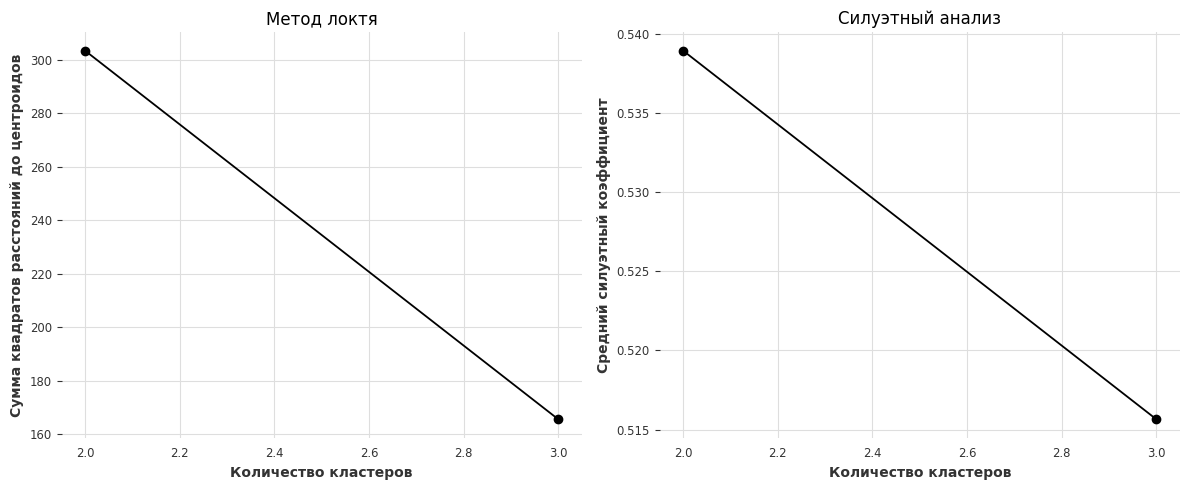

In [121]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

inertia_values = []
silhouette_scores = []

for n_clusters in tqdm(range(2, 4)): 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(principal_components)
    inertia_values.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(principal_components, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Метод локтя
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 4), inertia_values, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний до центроидов')

# Силуэтный анализ
plt.subplot(1, 2, 2)
plt.plot(range(2, 4), silhouette_scores, marker='o')
plt.title('Силуэтный анализ')
plt.xlabel('Количество кластеров')
plt.ylabel('Средний силуэтный коэффициент')
plt.tight_layout()
plt.show()

Выбираем 2 кластера

In [122]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(principal_components)

In [124]:
cluster_series = pd.Series(cluster_labels, index=aggregated_features_top_level_df.index, name='cluster')

clustered_df = aggregated_features_top_level_df.join(cluster_series)
clustered_df.head()

,dayofweek,month,year,new_tickets_lag_1,new_tickets_lag_2,new_tickets_lag_3,new_tickets_lag_7,new_tickets_lag_14,new_tickets_lag_21,new_tickets_lag_28,...,new_tickets_lag_14_rolling_mean_3,new_tickets_lag_14_rolling_median_3,new_tickets_lag_14_rolling_std_3,new_tickets_lag_14_rolling_mean_7,new_tickets_lag_14_rolling_median_7,new_tickets_lag_14_rolling_std_7,new_tickets_lag_14_rolling_mean_14,new_tickets_lag_14_rolling_median_14,new_tickets_lag_14_rolling_std_14,cluster
queue_id,,,,,,,,,,,,,,,,,,,,,
10,2.999253,6.343049,2018.432735,1825.889387,1824.158445,1822.233931,1816.292227,1804.370703,1793.148729,1782.047833,...,1802.767937,1787.467489,350.087563,1799.726685,1876.471599,461.364582,1794.151054,1860.410314,485.025737,1
34,2.999253,6.343049,2018.432735,919.308670,918.660688,917.824365,916.666667,913.691330,910.461136,906.301943,...,913.145366,899.190957,224.774945,912.579120,985.611360,294.447685,911.183441,974.387145,296.868725,1
40,2.919719,6.335931,2018.475448,23.431800,23.388153,23.361652,23.245518,23.004677,22.797350,22.579111,...,22.976228,22.519486,6.861844,22.921252,23.399454,8.109838,22.806165,23.058457,8.271264,0
115,2.999253,6.343049,2018.432735,657.917040,657.633782,657.351271,656.684604,655.197309,653.961883,652.686099,...,655.057673,652.640135,77.205696,654.785513,669.254858,98.371838,654.170737,666.034753,100.857845,0
201,2.969359,6.529248,2018.734448,8.987001,8.985144,8.983287,8.980501,8.973073,8.971216,8.966574,...,8.968431,8.548747,3.989745,8.963541,8.599814,4.657715,8.958427,8.369545,4.896389,0


In [125]:
cluster_profiles = clustered_df.groupby('cluster').mean()
cluster_profiles

,dayofweek,month,year,new_tickets_lag_1,new_tickets_lag_2,new_tickets_lag_3,new_tickets_lag_7,new_tickets_lag_14,new_tickets_lag_21,new_tickets_lag_28,...,new_tickets_lag_7_rolling_std_14,new_tickets_lag_14_rolling_mean_3,new_tickets_lag_14_rolling_median_3,new_tickets_lag_14_rolling_std_3,new_tickets_lag_14_rolling_mean_7,new_tickets_lag_14_rolling_median_7,new_tickets_lag_14_rolling_std_7,new_tickets_lag_14_rolling_mean_14,new_tickets_lag_14_rolling_median_14,new_tickets_lag_14_rolling_std_14
cluster,,,,,,,,,,,,,,,,,,,,,
0,2.955397,6.379929,2018.624783,223.190662,223.158107,223.046800,222.914845,222.624652,222.325571,221.839492,...,65.114865,222.594653,219.466864,48.871050,222.563392,229.753202,62.339752,222.426200,227.311524,65.104879
1,2.999253,6.343049,2018.432735,1021.749947,1020.678732,1019.522101,1017.078048,1012.217062,1007.191544,1001.549434,...,322.041734,1011.436508,997.426223,242.331799,1010.224702,1077.243007,314.160672,1007.874808,1066.667040,321.629106
